# Informe de Seguimiento

Este notebook contesta al punto opcional de la práctica de Riesgo de Crédito: "Informe de Seguimiento"

En primer lugar, hay que crear un modelo nuevo de predicción de mora. Nuestro grupo ha considerado que la mora es cuando LoanStatus es diferente a "Current", "Completed" o "FinalPaymentInProgress".

Seguidamente se hará un análisis de estabilidad y se contestará a algunos apartados.

## Carga de librerías y carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


In [2]:
from imblearn.over_sampling import SMOTE

C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
df_train = pd.read_csv('./prosperLoanData_train.csv')
df_oot = pd.read_csv('./prosperLoanData_oot.csv')

C:\Users\jcasa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Transformación de variables

Transformamos a binaria la variable "LoanStatus", asignando un "1" a lo que consideramos "Mora" y un "0" a lo que consideramos "Al corriente de pago".

In [4]:
df_train.LoanStatus.unique()

array(['Completed', 'Chargedoff', 'Current', 'Past Due (31-60 days)',
       'Past Due (16-30 days)', 'Defaulted', 'FinalPaymentInProgress',
       'Past Due (61-90 days)', 'Past Due (1-15 days)',
       'Past Due (91-120 days)', 'Past Due (>120 days)'], dtype=object)

In [5]:
df_train.loc[(df_train["LoanStatus"] == "Past Due (31-60 days)"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Past Due (16-30 days)"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Past Due (61-90 days)"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Past Due (1-15 days)"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Past Due (91-120 days)"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Past Due (>120 days)"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Chargedoff"), "LoanStatus"] = 1
df_train.loc[(df_train["LoanStatus"] == "Defaulted"), "LoanStatus"] = 1

df_train.loc[(df_train["LoanStatus"] == "Completed"), "LoanStatus"] = 0
df_train.loc[(df_train["LoanStatus"] == "Current"), "LoanStatus"] = 0
df_train.loc[(df_train["LoanStatus"] == "FinalPaymentInProgress"), "LoanStatus"] = 0

Hacemos lo mismo para el dataset de validación. Realizaremos esto para todos los pasos de transformación de variables.

In [6]:
df_oot.loc[(df_oot["LoanStatus"] == "Past Due (31-60 days)"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Past Due (16-30 days)"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Past Due (61-90 days)"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Past Due (1-15 days)"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Past Due (91-120 days)"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Past Due (>120 days)"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Chargedoff"), "LoanStatus"] = 1
df_oot.loc[(df_oot["LoanStatus"] == "Defaulted"), "LoanStatus"] = 1

df_oot.loc[(df_oot["LoanStatus"] == "Completed"), "LoanStatus"] = 0
df_oot.loc[(df_oot["LoanStatus"] == "Current"), "LoanStatus"] = 0
df_oot.loc[(df_oot["LoanStatus"] == "FinalPaymentInProgress"), "LoanStatus"] = 0

In [7]:
df_train.loc[(df_train["IncomeRange"] == "$25,000-49,999"), "IncomeRange"] = 3
df_train.loc[(df_train["IncomeRange"] == "$75,000-99,999"), "IncomeRange"] = 5
df_train.loc[(df_train["IncomeRange"] == "$50,000-74,999"), "IncomeRange"] = 4
df_train.loc[(df_train["IncomeRange"] == "$100,000+"), "IncomeRange"] = 6
df_train.loc[(df_train["IncomeRange"] == "$1-24,999"), "IncomeRange"] = 2
df_train.loc[(df_train["IncomeRange"] == "$0"), "IncomeRange"] = 1
df_train.loc[(df_train["IncomeRange"] == "Not employed"), "IncomeRange"] = 0

df_oot.loc[(df_oot["IncomeRange"] == "$25,000-49,999"), "IncomeRange"] = 3
df_oot.loc[(df_oot["IncomeRange"] == "$75,000-99,999"), "IncomeRange"] = 5
df_oot.loc[(df_oot["IncomeRange"] == "$50,000-74,999"), "IncomeRange"] = 4
df_oot.loc[(df_oot["IncomeRange"] == "$100,000+"), "IncomeRange"] = 6
df_oot.loc[(df_oot["IncomeRange"] == "$1-24,999"), "IncomeRange"] = 2
df_oot.loc[(df_oot["IncomeRange"] == "$0"), "IncomeRange"] = 1
df_oot.loc[(df_oot["IncomeRange"] == "Not employed"), "IncomeRange"] = 0

Se compruba cómo de balanceada está la variable objetivo "LoanStatus"

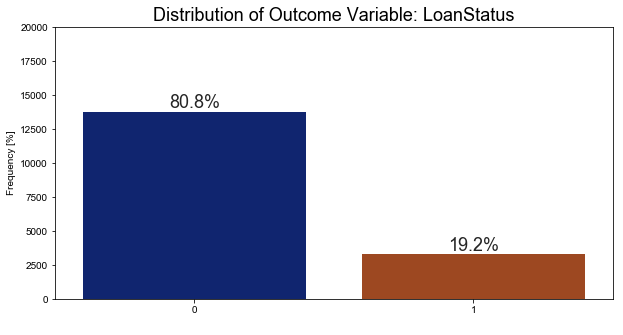

In [8]:
ax = sns.countplot(x = df_train.LoanStatus, palette="dark")
sns.set(font_scale=1.5)
ax.set_ylim(top = 400)
plt.title('Distribution of Outcome Variable: LoanStatus')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=20000)
ax.set_ylabel('Frequency [%]')
ncount = len(df_train)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
    ha='center', va='bottom')


plt.show()

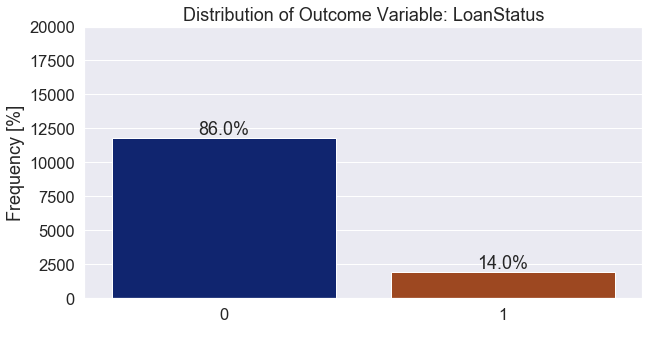

In [9]:
ax = sns.countplot(x = df_oot.LoanStatus, palette="dark")
sns.set(font_scale=1.5)
ax.set_ylim(top = 400)
plt.title('Distribution of Outcome Variable: LoanStatus')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=20000)
ax.set_ylabel('Frequency [%]')
ncount = len(df_oot)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
    ha='center', va='bottom')


plt.show()

Tanto para el dataset de entrenamiento como para el de validación, LoanStatus está muy desbalanceada, con aproximadamente un 80-20 de 0s y 1s

## Selección de variables

Puesto que en la práctica 3, esta ha sido la principal selección de variables para realizar los modelos, asumimos que es la mejor selección y realizaremos la predicción con estas variables.

In [10]:
df_train = df_train[["LoanStatus", 'CurrentCreditLines', 'InquiriesLast6Months', 'CreditScoreRangeLower',
                   'MonthlyLoanPayment', 'StatedMonthlyIncome', 'TotalTrades', "IsBorrowerHomeowner", "AmountDelinquent",
                   "IncomeRange"]]

In [11]:
df_oot = df_oot[["LoanStatus", 'CurrentCreditLines', 'InquiriesLast6Months', 'CreditScoreRangeLower',
                   'MonthlyLoanPayment', 'StatedMonthlyIncome', 'TotalTrades', "IsBorrowerHomeowner", "AmountDelinquent",
                   "IncomeRange"]]

In [12]:
df_train.head(2)

,LoanStatus,CurrentCreditLines,InquiriesLast6Months,CreditScoreRangeLower,MonthlyLoanPayment,StatedMonthlyIncome,TotalTrades,IsBorrowerHomeowner,AmountDelinquent,IncomeRange
0,0,8.0,2.0,660.0,172.6,3583.333333,17.0,True,0.0,3
1,1,4.0,0.0,660.0,174.2,3500.000000,6.0,False,0.0,3


In [13]:
df_oot.head(2)

,LoanStatus,CurrentCreditLines,InquiriesLast6Months,CreditScoreRangeLower,MonthlyLoanPayment,StatedMonthlyIncome,TotalTrades,IsBorrowerHomeowner,AmountDelinquent,IncomeRange
0,0,5.0,0.0,800.0,321.45,2875.0,26.0,True,10056.0,3
1,0,10.0,0.0,740.0,482.18,6250.0,32.0,False,0.0,5


## Análisis de Estabilidad de las Features

In [14]:
def PSI_numeric(series, in_out_time_series):
    """Returns the population stability index for numerical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']

    #base data deciles
    qqs = in_series.quantile(q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    #cut the data, based in the base series deciles
    in_series_cut = pd.cut(in_series, sorted(list(set(qqs.values))), include_lowest=True)
    out_series_cut = pd.cut(out_series, sorted(list(set(qqs.values))), include_lowest=True)
    #count volume per bin
    in_grp = in_series_cut.value_counts(dropna=False)
    out_grp = out_series_cut.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    #small fix, so some inf values are fixed
    out_grp[out_grp==0] = 0.01

    #N observations in each series
    N_in = len(in_series_cut)
    N_out = len(out_series_cut)

    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out

    return sum((in_grp-out_grp)*np.log(in_grp/out_grp))

In [15]:
def PSI_categorical(series, in_out_time_series):
    """Returns the population stability index for categorical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']
    
    #count volume per level
    in_grp = in_series.value_counts(dropna=False)
    out_grp = out_series.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    
    #N observations in each series
    N_in = len(in_series)
    N_out = len(out_series)
    
    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out
    
    #put all together in a df
    df_grp = in_grp.to_frame().join(out_grp.to_frame(), lsuffix = '_in', rsuffix = '_out')
    df_grp = df_grp.fillna(0.000001)

    return sum((df_grp.data_in - df_grp.data_out) * np.log(df_grp.data_in / df_grp.data_out))

In [16]:
psi = []
#capture in time - out of time series
it_oot_series = pd.Series(np.hstack((np.ones(len(df_train)), np.zeros(len(df_oot)))))
#for all features

features = ['CurrentCreditLines', 'InquiriesLast6Months', 'CreditScoreRangeLower',
                   'MonthlyLoanPayment', 'StatedMonthlyIncome', 'TotalTrades', "IsBorrowerHomeowner", "AmountDelinquent",
                   "IncomeRange"]
for c in features:
    col_series = pd.concat([df_train[c], df_oot[c]], ignore_index=True)
    if df_train[c].dtypes == object:
        psi.append(PSI_categorical(col_series, it_oot_series))
    else:
        psi.append(PSI_numeric(col_series, it_oot_series))

df_psi = pd.DataFrame({'feature': features,
                       'PSI': psi})
df_psi = df_psi.sort_values(by='PSI')

In [17]:
df_psi

,feature,PSI
6,IsBorrowerHomeowner,0.000000
7,AmountDelinquent,0.000074
1,InquiriesLast6Months,0.004000
8,IncomeRange,0.008847
4,StatedMonthlyIncome,0.011440
5,TotalTrades,0.014624
0,CurrentCreditLines,0.017994
2,CreditScoreRangeLower,0.032201
3,MonthlyLoanPayment,0.186034


## Profiling

In [18]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df_train)
profile.to_file(outputfile="output.html")

In [19]:
display(profile)

Number of variables,10
Number of observations,16987
Total Missing (%),0.0%
Total size in memory,1.2 MiB
Average record size in memory,73.0 B
Numeric,8
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,0


## Regresión Logística

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [21]:
X = df_train.drop("LoanStatus",axis=1)
y = df_train["LoanStatus"]

In [22]:
X.shape, y.shape

((16987, 9), (16987,))

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12740, 9), (4247, 9), (12740,), (4247,))

Como las muestras están desbalanceadas, decidimos hacer "oversampling"

In [24]:
sm = SMOTE(random_state=12, ratio = 0.6)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Comprobamos como está la muestra de entrenamiento

In [25]:
df = pd.DataFrame(y_train_res)

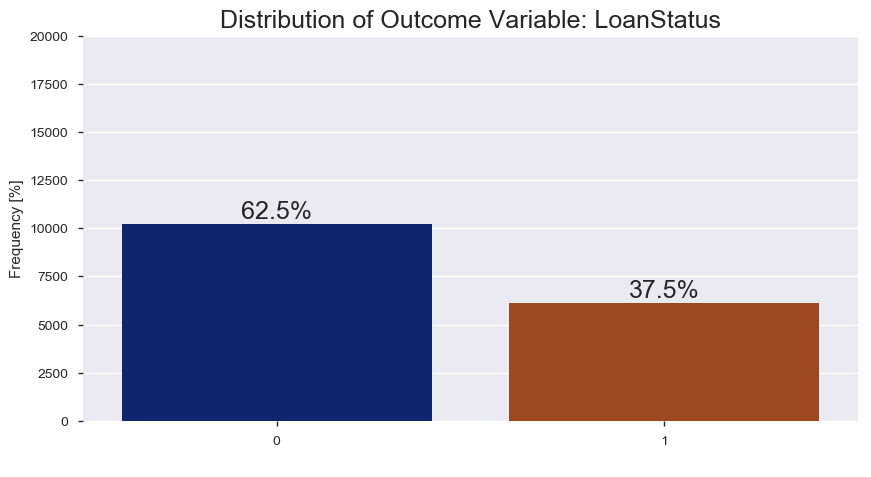

In [26]:
ax = sns.countplot(x = df[0], palette="dark")
sns.set(font_scale=1.5)
ax.set_ylim(top = 400)
plt.title('Distribution of Outcome Variable: LoanStatus')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=20000)
ax.set_ylabel('Frequency [%]')
ncount = len(df)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
    ha='center', va='bottom')


plt.show()

In [27]:
logit = LogisticRegression(random_state=42, solver="saga", penalty="l1", class_weight="balanced", C=1.0, max_iter=500)

In [28]:
scaler = StandardScaler().fit(x_train_res)

In [29]:
X_train_scaled = scaler.transform(x_train_res) #scaling features!
X_val_scaled = scaler.transform(X_val)

In [30]:
logit.fit(X_train_scaled, y_train_res)
logit_scores_proba = logit.predict_proba(X_train_scaled)
logit_scores = logit_scores_proba[:,1]

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

AUC Score 0.6591775730919968


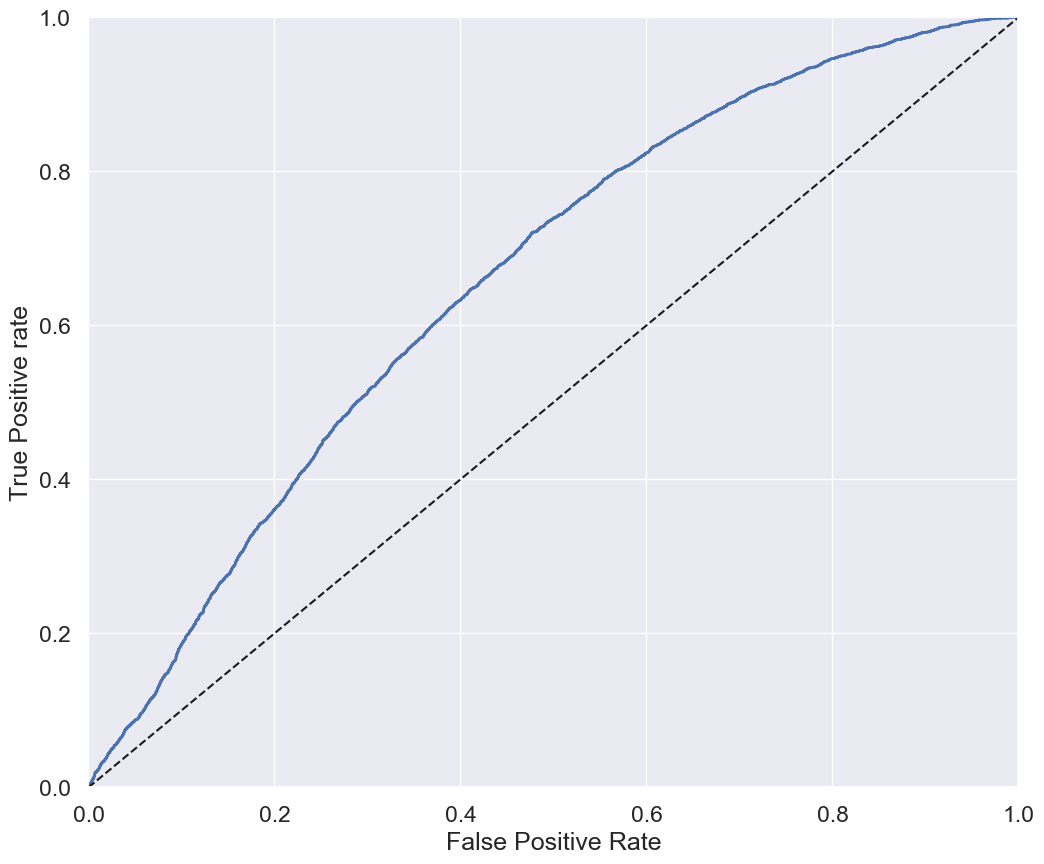

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train_res, logit_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_train_res,logit_scores)))

In [33]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_res)

C:\Users\jcasa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
Y_pred_rlog = logreg.predict(X_val_scaled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_val_scaled, y_val)))

Accuracy of logistic regression classifier on test set: 0.76


## Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators = 30)
random_forest.fit(x_train_res, y_train_res)
Y_pred_rfor = random_forest.predict(X_val)
print (random_forest.score(x_train_res, y_train_res))

0.9163050800966909


## Validación con OOT

Ahora vamos a validar nuestro modelo entrenado con el conjunto df_train con el conjunto de datos df_oot

In [38]:
kaggle = df_oot.drop('LoanStatus', axis=1)
logit_scores_proba = logit.predict_proba(kaggle)

In [39]:
prediccion_oot = pd.DataFrame(logit_scores_proba, columns=['Probabilidad', 'Prediccion'])

In [40]:
prediccion_oot_psi = pd.DataFrame(logit_scores_proba, columns=['Probabilidad', 'Prediccion'])

In [41]:
CutOff = 0.68
def myfun(x):
    if (x < CutOff):
        return 0
    else:
        return 1

In [42]:
prediccion_oot.Prediccion = prediccion_oot.Prediccion.apply(myfun)

In [43]:
prediccion_oot.Probabilidad.unique()

array([1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.32376967e-07,
       3.72746278e-12, 1.11342199e-06, 1.39152270e-03, 9.67547729e-08,
       3.98969746e-12, 9.99762033e-01, 1.00000000e+00, 9.99999974e-01,
       9.99999948e-01, 8.71689918e-02, 5.34459064e-04, 9.99999997e-01,
       9.99998626e-01, 1.00000000e+00, 7.32747196e-15, 1.00000000e+00,
       1.00000000e+00, 9.96795014e-01, 2.22051419e-04, 2.15184060e-05,
       9.99999864e-01, 9.99778450e-01, 8.44034620e-10, 1.00000000e+00,
       5.48285208e-01, 5.60194051e-02, 3.21807368e-06, 9.98920434e-01,
       4.88498131e-15, 9.99999987e-01])

In [44]:
prediccion_oot.Prediccion.unique()

array([0, 1], dtype=int64)

In [45]:
print('Nuestro modelo de regresión nos arroja un accuracy del: {:.2f}'.format(logit.score(kaggle, df_oot.LoanStatus)))

Nuestro modelo de regresión nos arroja un accuracy del: 0.85


In [46]:
prediccion_oot.Prediccion.sum()

289

La variable "Prediccion" del dataframe "prediccion_oot" arroja 0s y 1s, 1 significa que la prediccion dice que va a ser mora y 0 que no lo va a ser, con la probabilidad de la primera columna.

## Tasa de mora de la predicción para el conjunto de validación (df_oot)

In [47]:
TasaMoraoot = 100 * prediccion_oot.Prediccion.sum() / len(df_oot)
print ("La Tasa de Mora según la predicción es: {:.2f}%".format(TasaMoraoot))

La Tasa de Mora según la predicción es: 2.11%


Al comprobar la tasa de mora con el modelo entrenado con el conjunto de entrenamiento pero validado con el conjunto de validación, vemos que arroja una tasa excesivamente baja. Esto se debe a que la muestra estaba, como hemos demostrado antes, muy desbalanceada, pues ya sabiamos con anterioridad que había aproximadamente un 20% de 0s por lo que la tasa debería acercarse a esos numeros.

Sin embargo, en el siguiente capítulo demostramos cómo los modelos son buenos, pues al utilizar como conjunto de validación un split del conjunto del entrenamiento, la tasa de mora que nos arroja se acerca a lo que esperábamos.

## Tasas de Mora de las predicciones del conjunto de entrenamiento para validar en el conjunto de entrenamiento

In [48]:
TasaMoraLog = 100 * Y_pred_rlog.sum() / len(Y_pred_rlog.tolist())
print ("La Tasa de Mora según la predicción de la Regresión Logística es: {:.2f}%".format(TasaMoraLog))

La Tasa de Mora según la predicción de la Regresión Logística es: 15.59%


In [49]:
TasaMoraRF = 100 * Y_pred_rfor.sum() / len(Y_pred_rfor.tolist())
print ("La Tasa de Mora según la predicción del Random Forest es: {:.2f}%".format(TasaMoraRF))

La Tasa de Mora según la predicción del Random Forest es: 23.58%
